In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [50]:
files = [   
    'data/atp_rankings_70s.csv',
    'data/atp_rankings_80s.csv',
    'data/atp_rankings_90s.csv',
    'data/atp_rankings_00s.csv',
    'data/atp_rankings_10s.csv',
    'data/atp_rankings_20s.csv',
    'data/atp_rankings_current.csv'
]
rankings_df_list = [pd.read_csv(file) for file in files]
rankings_df = pd.concat(rankings_df_list, ignore_index=True)
players_df = pd.read_csv('data/atp_players.csv')

filenames = [f'data/atp_matches_{i}.csv' for i in range(1968, 2025)]
years = list(range(1968, 2025))
atp_matches_df_list = [pd.read_csv(filename) for filename in filenames]
atp_matches_df = pd.concat(atp_matches_df_list, ignore_index=True)

### ATP rankings

In [51]:
rankings_df

,ranking_date,rank,player,points
0,19730827,129,100005,NaN
1,19730827,114,100011,NaN
2,19730827,6,100016,NaN
3,19730827,19,100022,NaN
4,19730827,82,100025,NaN
...,...,...,...,...
3235634,20240527,2070,211388,1.0
3235635,20240527,2071,210649,1.0
3235636,20240527,2071,208890,1.0
3235637,20240527,2073,202079,1.0


In [52]:
players_df

,player_id,name_first,name_last,hand,dob,ioc,height,wikidata_id
0,100001,Gardnar,Mulloy,R,19131122.0,USA,185.0,Q54544
1,100002,Pancho,Segura,R,19210620.0,ECU,168.0,Q54581
2,100003,Frank,Sedgman,R,19271002.0,AUS,180.0,Q962049
3,100004,Giuseppe,Merlo,R,19271011.0,ITA,NaN,Q1258752
4,100005,Richard,Gonzalez,R,19280509.0,USA,188.0,Q53554
...,...,...,...,...,...,...,...,...
65014,212913,Pietro,Ricci,U,NaN,ITA,NaN,NaN
65015,212914,Corey,Craig,U,NaN,USA,NaN,NaN
65016,212915,Aleksandar,Ljubojevic,U,NaN,SRB,NaN,NaN
65017,212916,Marko,Milosavljevic,U,NaN,SRB,NaN,NaN


In [53]:
players_df['dob'] = pd.to_datetime(players_df['dob'], format='%Y%m%d', errors='coerce')
rankings_df['ranking_date'] = pd.to_datetime(rankings_df['ranking_date'], format='%Y%m%d', errors='coerce')

In [54]:
merged_df = pd.merge(rankings_df[rankings_df['points'] >= 10], players_df, left_on='player', right_on='player_id', how='left')
# merged_df = pd.merge(rankings_df, players_df, left_on='player', right_on='player_id', how='left')

In [55]:
merged_df.drop('wikidata_id', inplace=True, axis=1)

merged_df['ranking_date'] = pd.to_datetime(merged_df['ranking_date'], errors='coerce')
merged_df['age'] = ((merged_df['ranking_date'] - merged_df['dob']).dt.days / 365.25).round(2)
average_age_per_date = merged_df.groupby('ranking_date')['age'].mean()

In [56]:
merged_df

,ranking_date,rank,player,points,player_id,name_first,name_last,hand,dob,ioc,height,age
0,1990-01-01,1,100656,2913.0,100656,Ivan,Lendl,R,1960-03-07,USA,188.0,29.82
1,1990-01-01,2,101414,2279.0,101414,Boris,Becker,R,1967-11-22,GER,190.0,22.11
2,1990-01-01,3,101222,2111.0,101222,Stefan,Edberg,R,1966-01-19,SWE,188.0,23.95
3,1990-01-01,4,100763,1398.0,100763,Brad,Gilbert,R,1961-08-09,USA,185.0,28.40
4,1990-01-01,5,100581,1354.0,100581,John,McEnroe,L,1959-02-16,USA,180.0,30.87
...,...,...,...,...,...,...,...,...,...,...,...,...
1496676,2024-05-27,1094,209959,10.0,209959,Woobin,Shin,U,2004-01-20,KOR,NaN,20.35
1496677,2024-05-27,1096,210745,10.0,210745,Matthias,Ujvary,R,2004-07-05,AUT,180.0,19.89
1496678,2024-05-27,1097,208151,10.0,208151,Filippo,Speziali,U,2000-04-24,ITA,NaN,24.09
1496679,2024-05-27,1098,124074,10.0,124074,Kazuma,Kawachi,R,1994-10-11,JPN,NaN,29.63


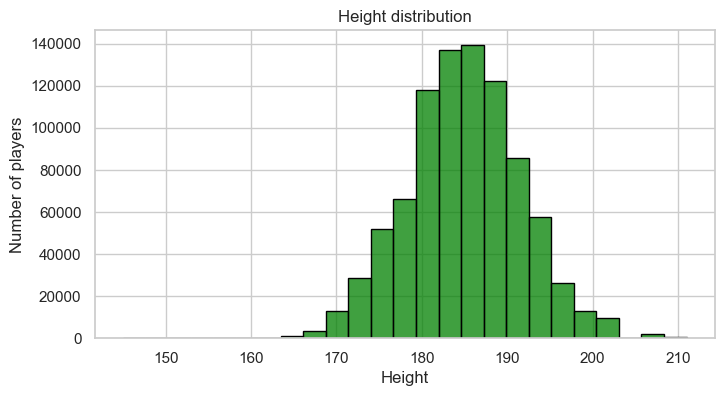

In [69]:
# Zakładając, że 'merged.df' zawiera kolumnę 'height'
height_data = merged_df['height']

sns.color_palette("rocket")
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(8, 4))  
sns.histplot(height_data, bins=25, kde=False, color='green', edgecolor='black')
plt.title('Height distribution') 
plt.xlabel('Height') 
plt.ylabel('Number of players')
plt.show()

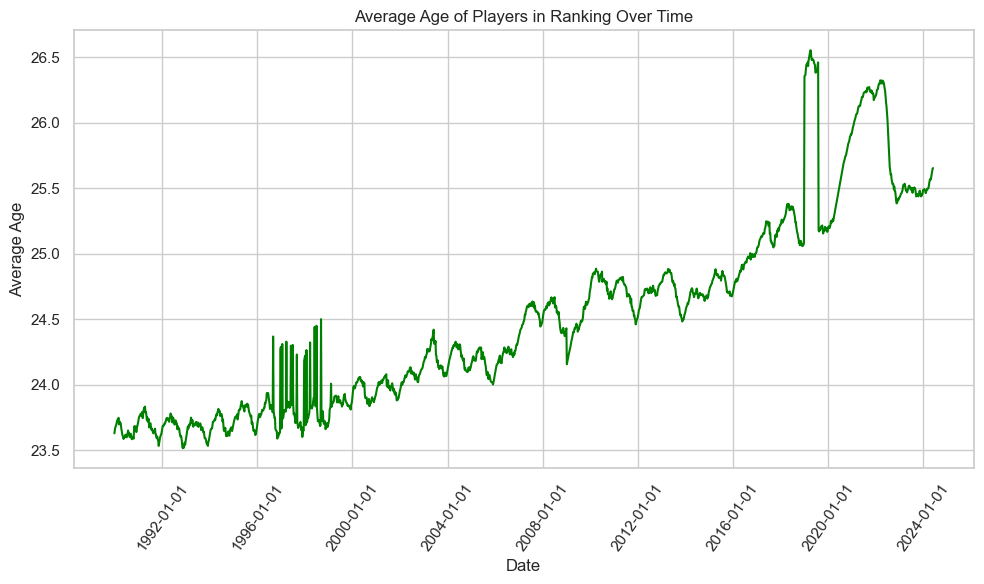

In [67]:
# plots
plt.figure(figsize=(10, 6))

plt.plot(average_age_per_date.index, average_age_per_date.values, linestyle='-', color='green')
plt.xlabel('Date')

plt.ylabel('Average Age')
plt.title('Average Age of Players in Ranking Over Time')
plt.grid(True)
date_format = mdates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)
plt.xticks(rotation=55)
plt.tight_layout()
plt.show()


### ATP matches

In [12]:
atp_matches_df

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,1968-2029,Dublin,Grass,32.0,A,19680708,270,112411,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1968-2029,Dublin,Grass,32.0,A,19680708,271,126914,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1968-2029,Dublin,Grass,32.0,A,19680708,272,209523,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1968-2029,Dublin,Grass,32.0,A,19680708,273,100084,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1968-2029,Dublin,Grass,32.0,A,19680708,274,100132,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193332,2024-M-DC-2024-WG2-PO-URU-MDA-01,Davis Cup WG2 PO: URU vs MDA,Clay,4.0,D,20240203,5,212051,NaN,NaN,...,30.0,17.0,7.0,6.0,8.0,14.0,1109.0,8.0,740.0,34.0
193333,2024-M-DC-2024-WG2-PO-VIE-RSA-01,Davis Cup WG2 PO: VIE vs RSA,Hard,4.0,D,20240202,1,122533,NaN,NaN,...,41.0,25.0,6.0,9.0,1.0,4.0,554.0,67.0,748.0,32.0
193334,2024-M-DC-2024-WG2-PO-VIE-RSA-01,Davis Cup WG2 PO: VIE vs RSA,Hard,4.0,D,20240202,2,144748,NaN,NaN,...,51.0,25.0,7.0,11.0,5.0,12.0,416.0,109.0,NaN,NaN
193335,2024-M-DC-2024-WG2-PO-VIE-RSA-01,Davis Cup WG2 PO: VIE vs RSA,Hard,4.0,D,20240202,4,122533,NaN,NaN,...,51.0,32.0,17.0,14.0,5.0,9.0,554.0,67.0,416.0,109.0


In [13]:
atp_matches_df['tourney_date'] = pd.to_datetime(atp_matches_df['tourney_date'], format='%Y%m%d', errors='coerce')

In [14]:
atp_matches_df

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,1968-2029,Dublin,Grass,32.0,A,1968-07-08,270,112411,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1968-2029,Dublin,Grass,32.0,A,1968-07-08,271,126914,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1968-2029,Dublin,Grass,32.0,A,1968-07-08,272,209523,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1968-2029,Dublin,Grass,32.0,A,1968-07-08,273,100084,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1968-2029,Dublin,Grass,32.0,A,1968-07-08,274,100132,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193332,2024-M-DC-2024-WG2-PO-URU-MDA-01,Davis Cup WG2 PO: URU vs MDA,Clay,4.0,D,2024-02-03,5,212051,NaN,NaN,...,30.0,17.0,7.0,6.0,8.0,14.0,1109.0,8.0,740.0,34.0
193333,2024-M-DC-2024-WG2-PO-VIE-RSA-01,Davis Cup WG2 PO: VIE vs RSA,Hard,4.0,D,2024-02-02,1,122533,NaN,NaN,...,41.0,25.0,6.0,9.0,1.0,4.0,554.0,67.0,748.0,32.0
193334,2024-M-DC-2024-WG2-PO-VIE-RSA-01,Davis Cup WG2 PO: VIE vs RSA,Hard,4.0,D,2024-02-02,2,144748,NaN,NaN,...,51.0,25.0,7.0,11.0,5.0,12.0,416.0,109.0,NaN,NaN
193335,2024-M-DC-2024-WG2-PO-VIE-RSA-01,Davis Cup WG2 PO: VIE vs RSA,Hard,4.0,D,2024-02-02,4,122533,NaN,NaN,...,51.0,32.0,17.0,14.0,5.0,9.0,554.0,67.0,416.0,109.0
